# Módulo de preprocesamiento 
Ammi Beltrán & Fernanda Borja

## Importado de librerias

In [ ]:
# ! pip install -U scikit-learn

In [16]:
import os
import mne
import glob
#
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import pandas as pd
import torch 
from dataprep2 import Masking

Se crea el path de data

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")
    print("Data directory created :D")

Dirección del dataset

In [3]:
# EDFDIR = "D:\\OneDrive\\OneDrive - Universidad de Chile\\Semestre X\\Inteligencia\\Proyecto\\dataset\\tuh_eeg"
# EDFDIR = "c:\\Users\\TheSy\\Desktop\\tuh_eeg"
# EDFDIR = "C:\\Users\\TheSy\\Desktop\\FinalEL7006\\test"
EDFDIR = "C:\\Users\\TheSy\\Desktop\\tests"
files = glob.glob(EDFDIR + '/**/*.edf', recursive=True)

## Preprocesamiento

### Funciones
* Una vez funcione mover a .py y traer como librería 

Seleccion de canales

In [4]:
def channel_select(data, channels):
    '''
    Selects channels from array 
    '''
    extracted = data.pick(channels, exclude="bads")
    return extracted

Clipeo

In [5]:
def clip(data, channels,max= 500e-6):
    def cliper(array):
        for i in range(len(array)):
            if abs(array[i]) > max:
                array[i] = math.copysign(max,array[i])
        return array
    data.apply_function(cliper, picks=channels, channel_wise= True)

Filtrado

In [6]:
def eeg_filter(data, lfreq = 1, hfreq= 70):
    '''
    
    '''
    data_copy = copy.copy(data)
    filtered = data_copy.filter(#l_freq = lfreq,
                                l_freq = lfreq,
                                h_freq = hfreq,
                                method = "iir",
                                )
    filtered = filtered.filter(#l_freq = lfreq,
                                l_freq = 61,
                                h_freq = 59,
                                method = "iir",
                                )
    return filtered

Corte de primero minuto y de max

In [7]:
def temporal_crop(data, tin = 60, tfin = 12*60):
    ''' 
    Cut the channels from the second "tin" to "tfin"
    '''
    data_copy = copy.copy(data)
    croped = data_copy.crop(tmin = tin, tmax = min(tfin, int(data.times[-1])))
    return croped

Marcado de épocas

In [8]:
# eventos
def get_epochs(data, channels, window = 10):
    ''' 
    window es la ventana de tiempo
    '''
    data_copy = copy.copy(data)
    # Create events
    events = mne.make_fixed_length_events(data_copy, duration = window, first_samp = True)
    # Divide accordingly
    picks = channels
    epochs = mne.Epochs(raw = data_copy, events = events, picks = picks,
                        tmin = 0., tmax = window, baseline = None,
                        flat = dict(eeg = 1e-6))
    
    epochs.drop(-1,reason = "Unfixed duration")
    return epochs

Downsample

In [9]:
def downsample(epoch, freq = 200):
    ''' 
    Downsamples the data given by a factor
    En nuestro caso, down corresponde a (frecuencia que queremos)/(frecuencia actual)
    '''
    down = epoch.resample(freq, npad = "auto")
    return down

Normalización

In [10]:
def normalization(epochs):
    obj = mne.decoding.Scaler(info = epochs.info, scalings= "mean",with_mean= True, with_std= True)
    # values = obj.fit_transform(epochs)
    values = obj.fit_transform(epochs.get_data())
    return values

***

Union

## Uso de funciones

In [15]:
raw = mne.io.read_raw_edf(files[0], preload=True)
# raw.plot(duration = 20, start = 60)

Extracting EDF parameters from C:\Users\TheSy\Desktop\tests\aaaaaaaa\s001_2015_12_30\01_tcp_ar\aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...


In [16]:
channeled = channel_select(raw,raw.ch_names[:19] )
# raw.compute_psd().plot()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 70.00 Hz: -6.02, -6.02 dB



Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.00, 61.00 Hz: -6.02, -6.02 dB



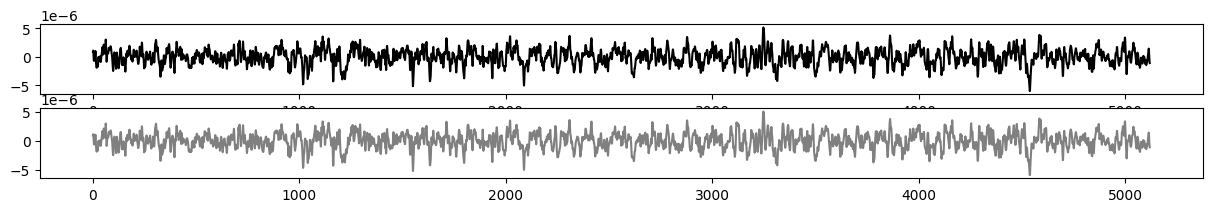

In [27]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize = (15,2))

ax1.plot(channeled.get_data()[0][60*256:80*256],color = "black")
filtered = eeg_filter(channeled)
ax2.plot(filtered.get_data()[0][60*256:80*256], color = "gray")
plt.show()

***

In [18]:
trimmed = temporal_crop(filtered)

In [ ]:
ch1 = trimmed.get_data()[3]

In [ ]:
trimmed.compute_psd(average = "mean").plot()
plt.xticks(np.arange(0,120,10))
plt.show()

In [ ]:
trimmed.plot(duration = 20)

In [21]:
raw_avg_ref = trimmed.copy().set_eeg_reference(ref_channels="average")
raw_avg_ref = downsample(raw_avg_ref)
# raw_avg_ref.plot(duration = 20, start = 0)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [37]:
def EDFprep(edf, n_channels = 19, norm = True, random = True, ):
    '''
    Pipeline
    '''

    #Random channel select
    channels = edf.ch_names
    if random:
        ch = np.random.choice(channels[:-3], size = n_channels, replace=False)
    else:
        ch = channels[:n_channels]
    
    channel_data = channel_select(edf, ch)
    clip(channel_data,ch)
    if(int(edf.times[-1]) < 100):
        return np.empty(0)
    filtered = eeg_filter(channel_data)
    trimmed_data = temporal_crop(filtered)
    down_data = downsample(trimmed_data)
    epochs = get_epochs(down_data, ch)
    if norm:
        norm_data = normalization(epochs)
        norm_data = np.delete(norm_data,-1,2)
        return norm_data  
    return epochs


In [36]:
def EDFprep2(edf, n_channels = 19, norm = True, random = True, ):
    '''
    Pipeline
    '''

    #Random channel select
    channels = edf.ch_names
    if random:
        ch = np.random.choice(channels[:-3], size = n_channels, replace=False)
    else:
        ch = channels[:n_channels]
    
    channel_data = channel_select(edf, ch)
    filtered = eeg_filter(channel_data)
    clip(filtered, ch)
    trimmed_data = temporal_crop(filtered)
    re_ref = trimmed_data.copy().set_eeg_reference(ref_channels="average")
    down_data = downsample(re_ref)
    epochs = get_epochs(down_data,down_data.ch_names)

    if norm:
        norm_data = normalization(epochs)
        norm_data = np.delete(norm_data,-1,2)
        return norm_data 
    return epochs


In [13]:
raw = mne.io.read_raw_edf(files[0], preload=True)
procesed = EDFprep2(raw, norm = True,random = False,)
# raw.ch_names

Extracting EDF parameters from C:\Users\TheSy\Desktop\tests\aaaaaaaa\s001_2015_12_30\01_tcp_ar\aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 70.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.00, 61.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [17]:
ch = procesed[0][0]

In [24]:
cht = Masking(ch)
chtp = Masking(ch)

In [27]:
cht.shape

(2000,)

In [30]:
a = torch.from_numpy(np.vstack([cht,chtp])).type(torch.FloatTensor)

In [35]:
a.type()

'torch.FloatTensor'

In [60]:
type(mne.compute_raw_covariance(raw))

Using up to 6325 segments
Number of samples used : 322575
[done]


mne.cov.Covariance

C:\Users\TheSy\AppData\Local\Temp\ipykernel_17688\2860153620.py:1: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  procesed.plot(n_epochs = 1)


Using data from preloaded Raw for 1 events and 2001 original time points ...


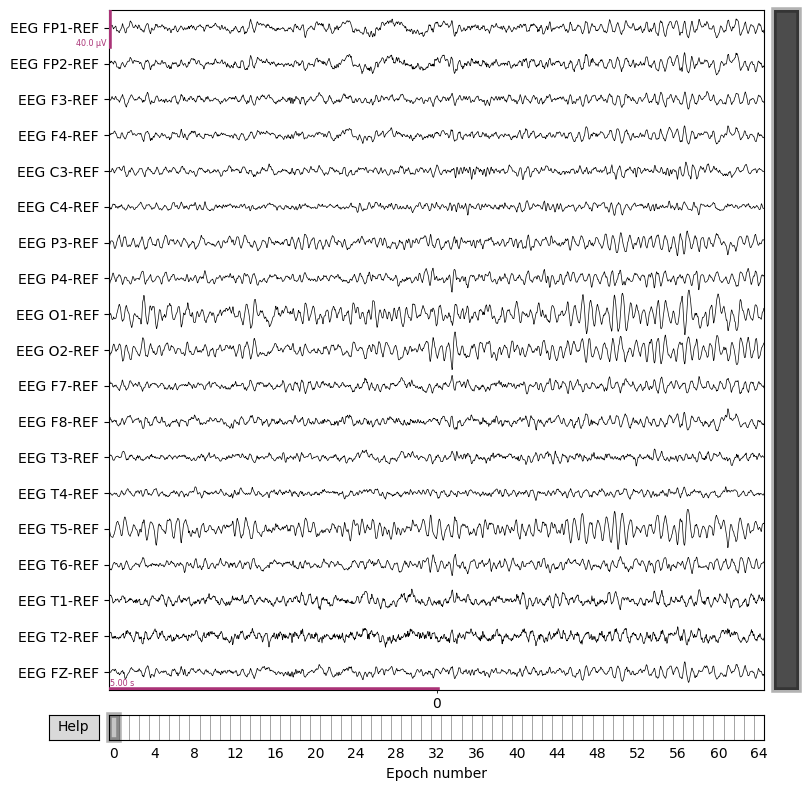

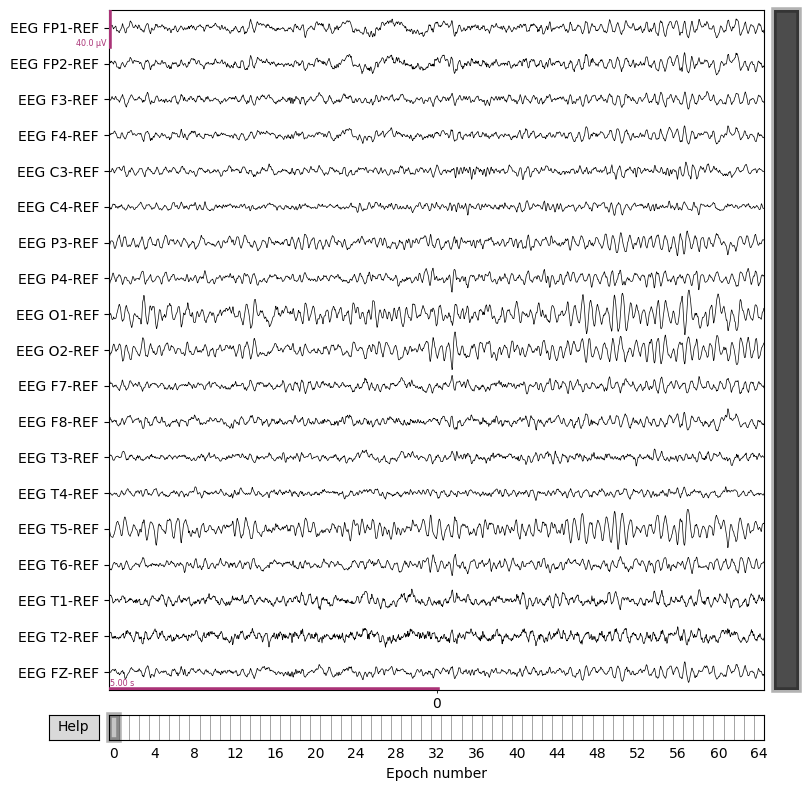

In [43]:
procesed.plot(n_epochs = 1)

In [ ]:
# torch.save(procesed,"LSTMData-0.001.pt")
# train_loader(batch_size= 2*19, multi = False)

In [37]:
def Save_win(data,loc_df, save_dir, patient_id,session_id, save = False):

    for i, win in enumerate(data):
        sdir = f"{save_dir}\\{patient_id}\\{patient_id}_{session_id}_w{i+1}.pt"
        loc_df.loc[len(loc_df)] = [patient_id,session_id,i+1,sdir]

        if save:
            torch.save(win,sdir)
    return loc_df

def Save_ch(data,loc_df, save_dir, patient_id,session_id, save = False):
    
    for i, win in enumerate(data):
        for j, ch in enumerate(win):
            sdir = f"{save_dir}\\{patient_id}\\{patient_id}_{session_id}_w{i+1}_ch{j+1}.pt"
            loc_df.loc[len(loc_df)] = [patient_id,session_id,i+1,sdir]
            
            if save:
                cht = Masking(ch)
                chtp = Masking(ch)
                ch_save = torch.from_numpy(np.vstack([cht,chtp])).type(torch.FloatTensor)
                torch.save(ch_save , sdir)
    return loc_df

In [40]:
def prep(path, save = False,mode = "per_win", save_dir = "data", sep = "\\"):
    ''' 
    Lectura de todos los edfs de cada paciente, guardado de ventanas temporales y csv de direcciones

    Inputs:
        -path
    Output:
        -dir_csv: csv con todos los datos de guardado de las ventanas de cada edf.    
    '''
    LEN_PAT = 8
    SESION_LEN = 15
    loc_df = pd.DataFrame(columns= ["Patient", "Session","N_Win", "Dir"], )
    save_dir = os.path.join(save_dir, mode)

    if save:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print("Data directory created :D")
    

    patient_path = glob.glob(path + '/**')
    for patient in patient_path:

        #Para guardar la id en el DF
        patient_id = patient[-LEN_PAT:]

        if save:
            if not os.path.exists(os.path.join(save_dir, patient_id)):
                os.makedirs(os.path.join(save_dir, patient_id))
        
        sessions = glob.glob(patient + '/**')
        for session in sessions:

            #Para guardar la sesion correspondiente
            session_id = session[-SESION_LEN:-(SESION_LEN - 4)]

            edfs = glob.glob(session+ "/**/*.edf")
            for edf in edfs:

                raw = mne.io.read_raw_edf(edf,preload=True)
                try:
                    data = EDFprep2(raw,random = False)
                except:
                    print(f"{patient_id}_{session_id} failed")
                    continue
                if mode == "per_win":
                    loc_df = Save_win(data,loc_df,save_dir,patient_id,session_id, save)
                elif mode == "per_channel":
                    loc_df = Save_ch(data,loc_df,save_dir,patient_id,session_id,save)

    if save:
        if mode == "per_channel":
            loc_df.to_csv("prep_channels.csv", encoding= "utf-8" )
        elif mode == "per_win":
            loc_df.to_csv("prep_windows.csv", encoding= "utf-8")
                
    return loc_df

In [41]:
df = prep(EDFDIR, True, "per_channel")

Data directory created :D
Extracting EDF parameters from C:\Users\TheSy\Desktop\tests\aaaaaaaa\s001_2015_12_30\01_tcp_ar\aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 70.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.00, 61.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a c

In [81]:
def EDFplot(edf_path, vs_prep = False, win_s = 10, f_prep = 200,n_epoch = 0 ):
    '''
    Plot the first window after 60s of the edf 
    '''
    print(f"Ploting {edf_path}")
    names = ["Original", "Prep"]
    raw = mne.io.read_raw_edf(edf_path, preload= True)
    raw_freq = int(raw.info["sfreq"])
    raw_data = raw.get_data()
    first_channel = raw_data[0]

    n_axes = 1 + vs_prep * 1

    fig, axes = plt.subplots(nrows = n_axes, figsize=(30, 3))

    n_ep = n_epoch
    # first_win_original = first_channel[(60)*raw_freq:(60+win_s)*raw_freq]
    first_win_original = first_channel[(60 + n_ep*win_s)*raw_freq:(60 + n_ep*win_s + win_s)*raw_freq]
    
    if vs_prep:
        # print(raw)
        prep = EDFprep2(raw,n_channels = 19, random = False)
        first_win_processed = np.squeeze(prep[n_ep][1])
        axes[0].plot(first_win_original, color = "black", label = names[0])
        axes[0].set_title(f"{names[0]} edf")
        axes[0].set_ylabel("uVoltage [Vs]")

        axes[1].plot(first_win_processed, color = "gray", label = names[1])
        axes[1].set_title(f"{names[1]} edf")
        axes[1].set_ylabel("uVoltage [Vs]")
        axes[1].set_xlabel("Samples [s*Hz]")
    else:
        axes.plot(first_win_original,color = "black", label = names[0])
        axes.set_title(f"{names[0]} edf")
        axes.set_ylabel("uVoltage [Vs]")
        axes.set_xlabel("Samples [s*Hz]")
    plt.show()

    




Ploting C:\Users\TheSy\Desktop\tests\aaaaaaaa\s001_2015_12_30\01_tcp_ar\aaaaaaaa_s001_t000.edf
Extracting EDF parameters from C:\Users\TheSy\Desktop\tests\aaaaaaaa\s001_2015_12_30\01_tcp_ar\aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 70.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.00, 61.00 Hz: -6.02, -6.02 dB

EEG channel type

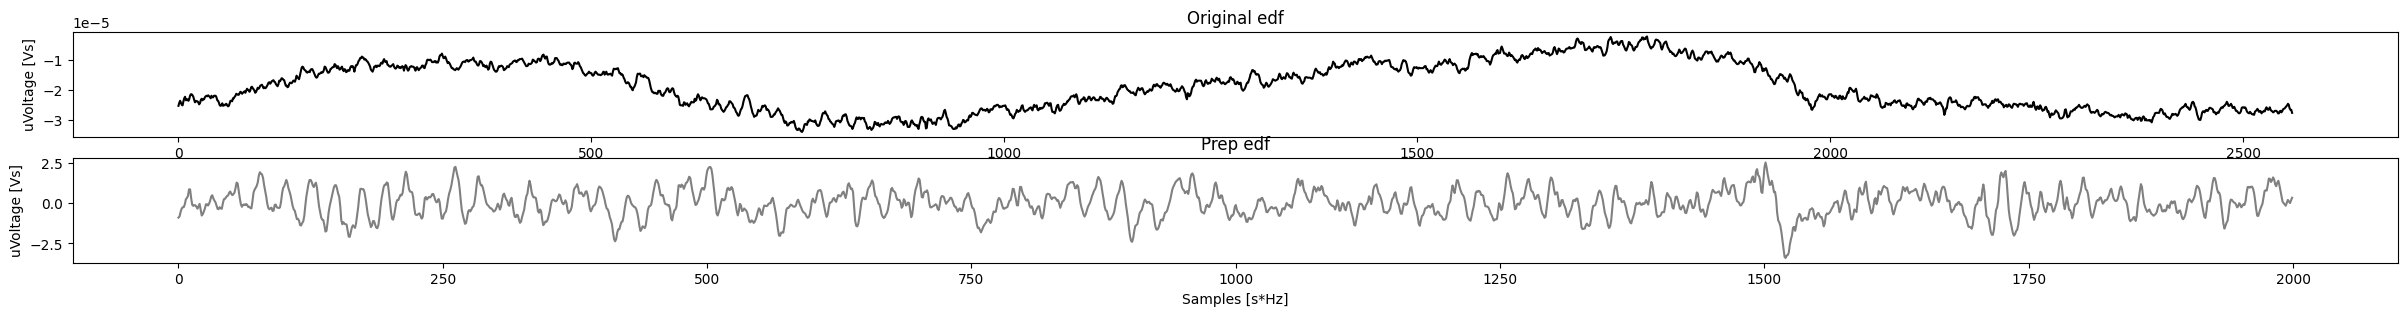

In [82]:
EDFplot(files[0], vs_prep = True, n_epoch= 1)